In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader

%load_ext autoreload
%autoreload 2

2025-09-07 04:53:03.931938: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 04:53:04.163332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-07 04:53:04.163373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-07 04:53:04.185265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-07 04:53:04.269984: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load catalogs

In [3]:
dir_cat = '../data/shame_catalogues_to_share'
fn_cat = '{cat_dir}/kate_sham_catalogue_a1.0_par_b_Planck_N3072_L1024_0.00.h5'

In [4]:
cat = h5py.File(fn_cat.format(cat_dir=dir_cat), 'r')

In [5]:
cat.keys()

<KeysViewHDF5 ['gal_central', 'gal_ids', 'gal_mstar', 'gal_pos', 'gal_vel', 'parent_index', 'parent_m200']>

In [6]:
cat['gal_pos'].shape

(579820, 3)

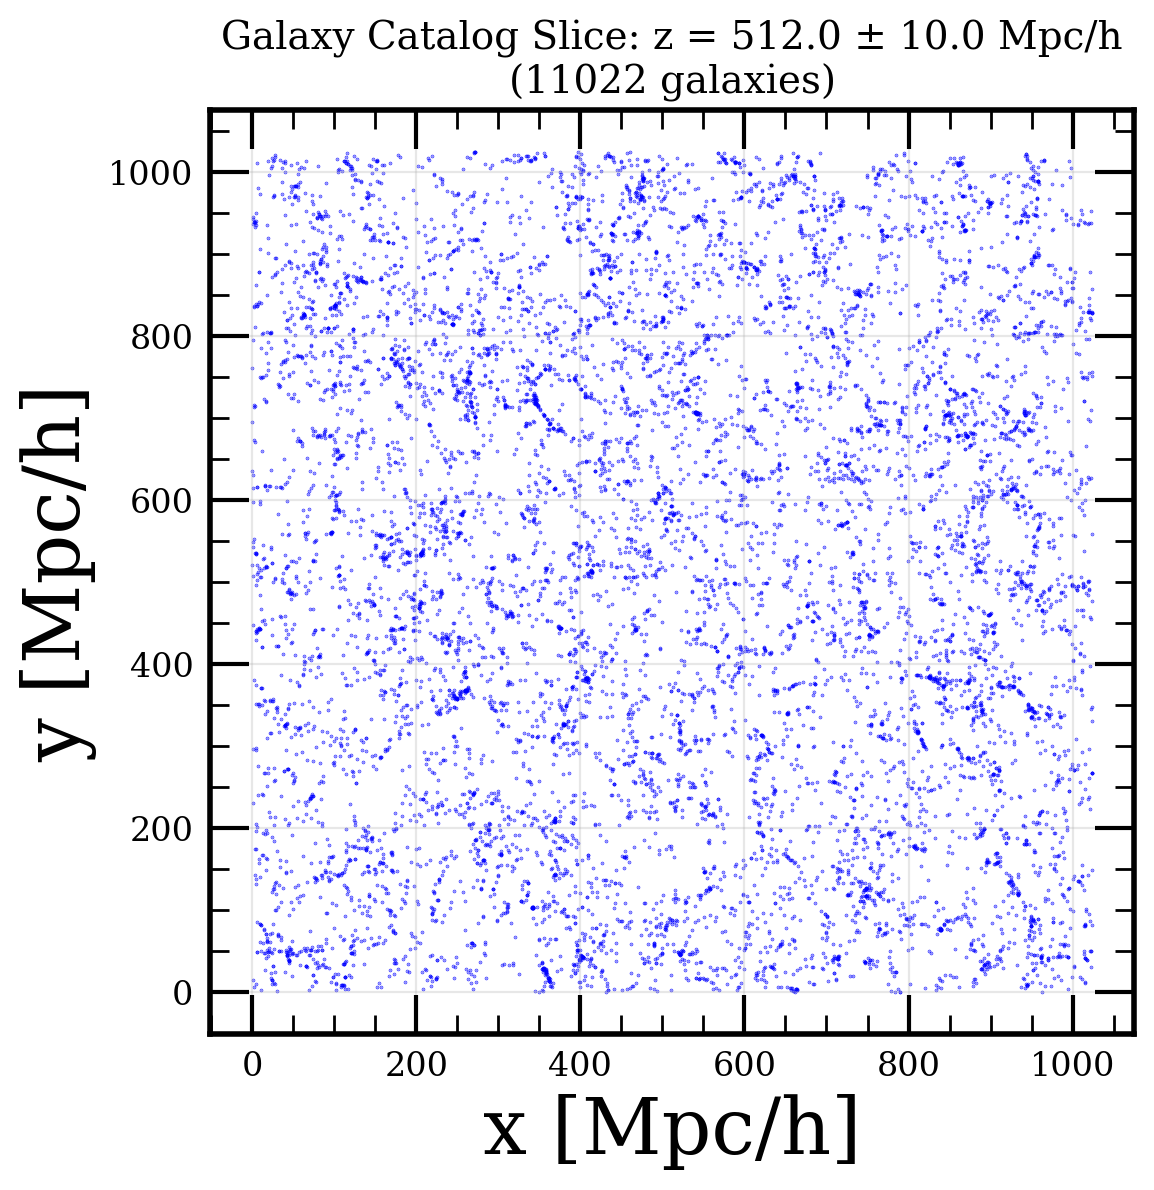

Catalog box size appears to be: [1023.9997  1023.99756 1023.9987 ] Mpc/h
Number of galaxies in catalog: 579820


In [7]:
# Example usage: plot a slice at z=512 with width of 20 Mpc/h
fig, ax = plotter.plot_catalog_slice(cat, z_center=512, z_width=20)
plt.show()

print(f"Catalog box size appears to be: {cat['gal_pos'][:].max(axis=0)} Mpc/h")
print(f"Number of galaxies in catalog: {len(cat['gal_pos'][:])}")

In [8]:
n_grid = 128
n_grid_orig = 512
box_size_mock = 1024.
box_size_muchisimocks = 1000.

# because we'll want even for ffts
def round_to_nearest_even(x):
    return int(round(x / 2) * 2)

n_grid_orig_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_orig))
n_grid_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid))
print(f"Resampling to {n_grid_orig_mock}^3 / {n_grid_mock}^3 grid (from {n_grid_orig}^3/{n_grid}^3 original grid)")

Resampling to 524^3 / 132^3 grid (from 512^3/128^3 original grid)


In [9]:
cat_mesh_ngorig = bacco.statistics.compute_mesh(ngrid=n_grid_orig_mock, box=box_size_mock, pos=cat['gal_pos'][:], 
                                     vel=None, mass=None,
                 interlacing=False, deposit_method='cic',
                 zspace=False, cosmology=None)
print(cat_mesh_ngorig.shape)

2025-09-07 04:53:13,029 bacco.statistics : Computing cic mesh with ngrid=524 and interlacing=False
2025-09-07 04:53:13,030 bacco.statistics : starting deposit 1
2025-09-07 04:53:14,123 bacco.statistics :  mesh done in 1.09 s


bacco.mesh : boxsize=1024.000000 ngrid=524, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 548.9 Mb
bacco.mesh : binning of 579820 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 524, 524, 524)


In [10]:
cat_mesh_direct = bacco.statistics.compute_mesh(ngrid=n_grid_mock, box=box_size_mock, pos=cat['gal_pos'][:], 
                                     vel=None, mass=None,
                 interlacing=False, deposit_method='cic',
                 zspace=False, cosmology=None)
print(cat_mesh_direct.shape)

2025-09-07 04:53:14,634 bacco.statistics : Computing cic mesh with ngrid=132 and interlacing=False
2025-09-07 04:53:14,634 bacco.statistics : starting deposit 1
2025-09-07 04:53:14,822 bacco.statistics :  mesh done in 0.188 s


bacco.mesh : boxsize=1024.000000 ngrid=132, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.8 Mb
bacco.mesh : binning of 579820 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 132, 132, 132)


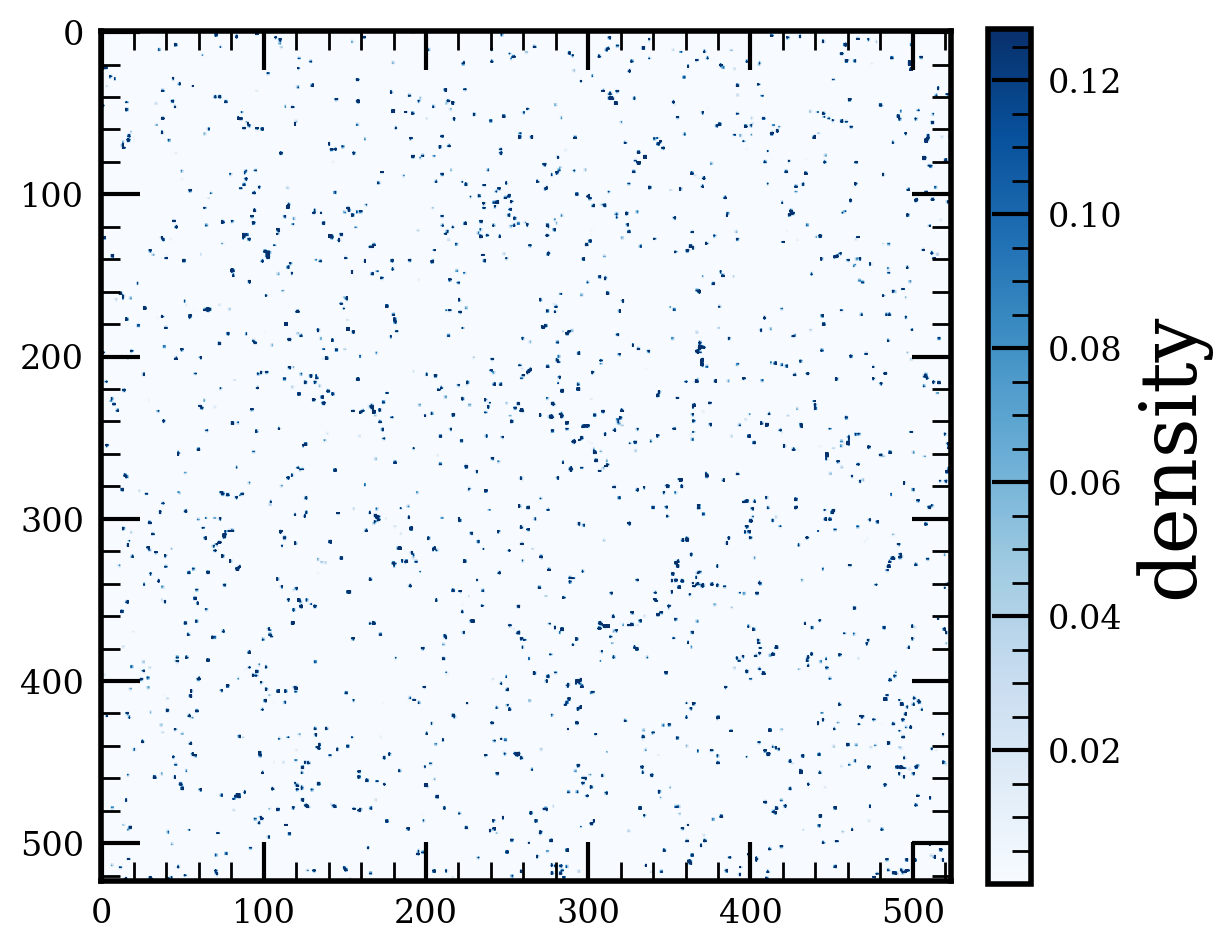

In [11]:
plotter.plot_field(cat_mesh_ngorig[0], overdensity=False)

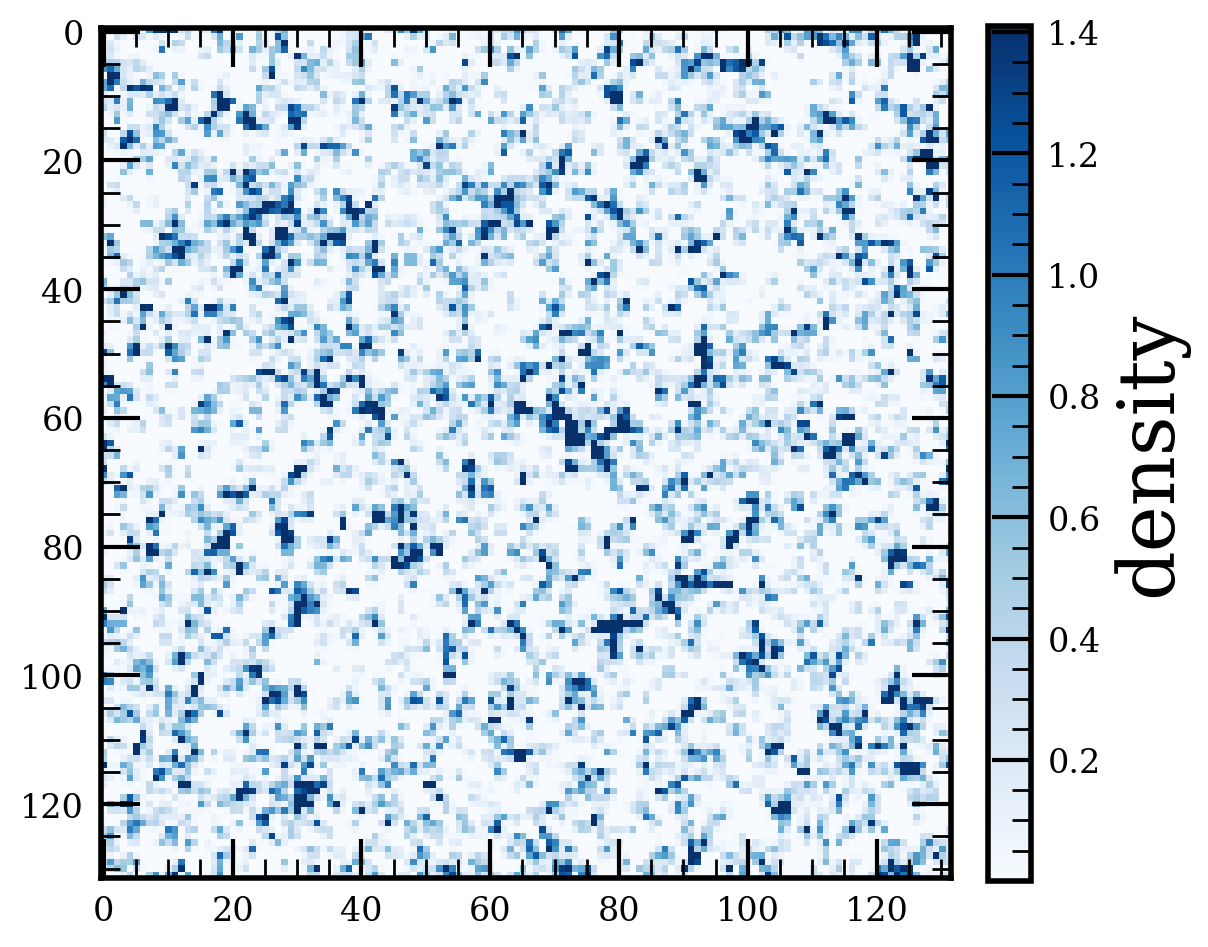

In [12]:
plotter.plot_field(cat_mesh_direct[0], overdensity=False)

In [13]:
def remove_highk_modes(field, box_size_mock, n_grid_target):
    n_grid = field.shape[-1]
    k_nyq = np.pi/box_size_mock*n_grid_target
    kmesh = bacco.visualization.np_get_kmesh( (n_grid, n_grid, n_grid), box_size_mock, real=True)
    mask = (kmesh[:,:,:,0]<=k_nyq) & (kmesh[:,:,:,1]<=k_nyq) & (kmesh[:,:,:,2]<=k_nyq) & (kmesh[:,:,:,0]>-k_nyq) & (kmesh[:,:,:,1]>-k_nyq) & (kmesh[:,:,:,2]>-k_nyq)
    field_kcut = []
    assert n_grid_target%2==0, "n_grid_target must be even!"

    deltak = pyfftw.builders.rfftn(field, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
    deltakcut = deltak()[mask]
    deltakcut= deltakcut.reshape(n_grid_target, n_grid_target, int(n_grid_target/2)+1)
    field_kcut = pyfftw.builders.irfftn(deltakcut, axes=(0,1,2))()
        
    return field_kcut

In [14]:
cat_field_kcut = remove_highk_modes(cat_mesh_ngorig[0], box_size_mock=box_size_mock, n_grid_target=n_grid_mock)

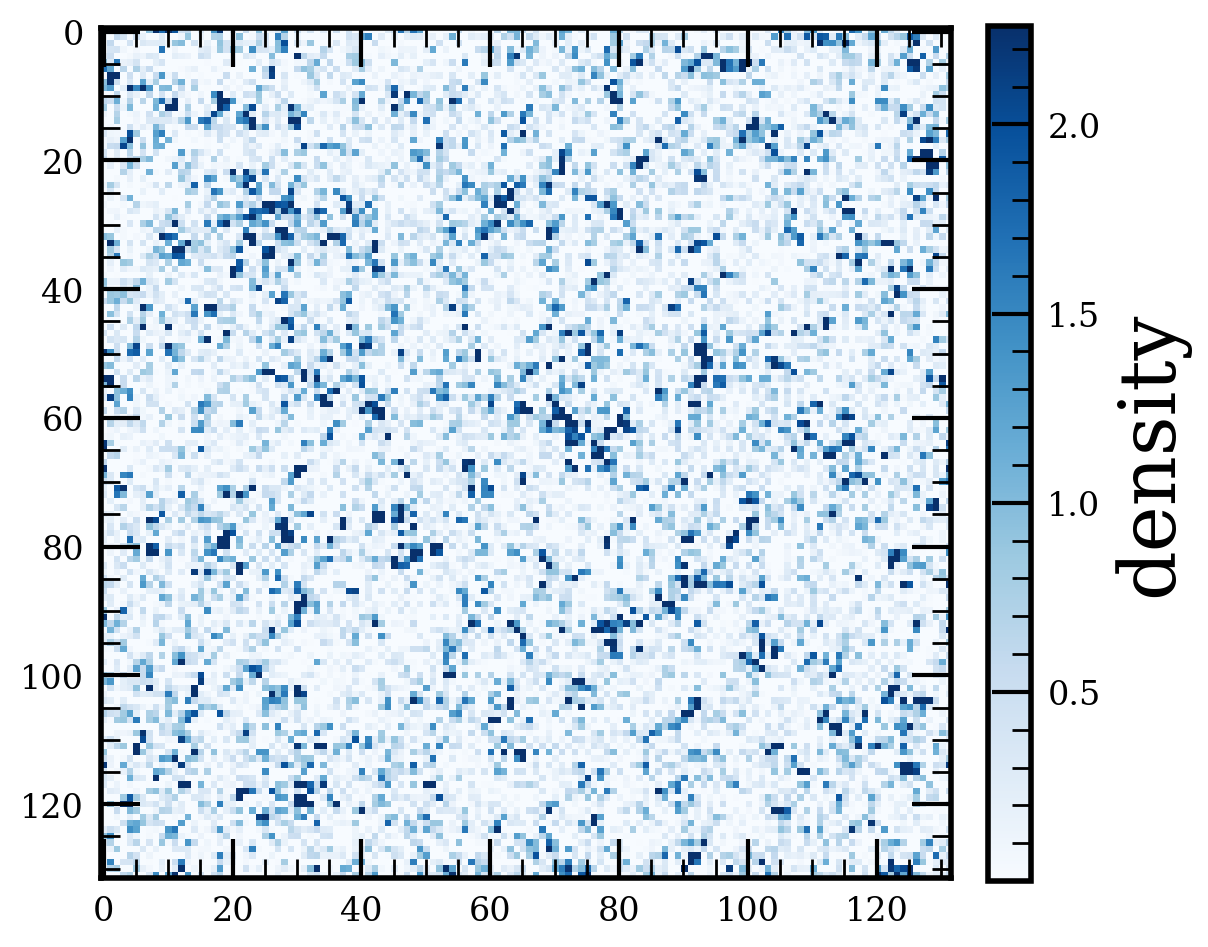

In [15]:
plotter.plot_field(cat_field_kcut, overdensity=False)

In [17]:
cat_overdensity= (cat_field_kcut - np.mean(cat_field_kcut))/np.mean(cat_field_kcut)
cat_overdensity /= n_grid_mock**3 

In [18]:
cat_field_kcut.shape, cat_overdensity.shape

((132, 132, 132), (132, 132, 132))

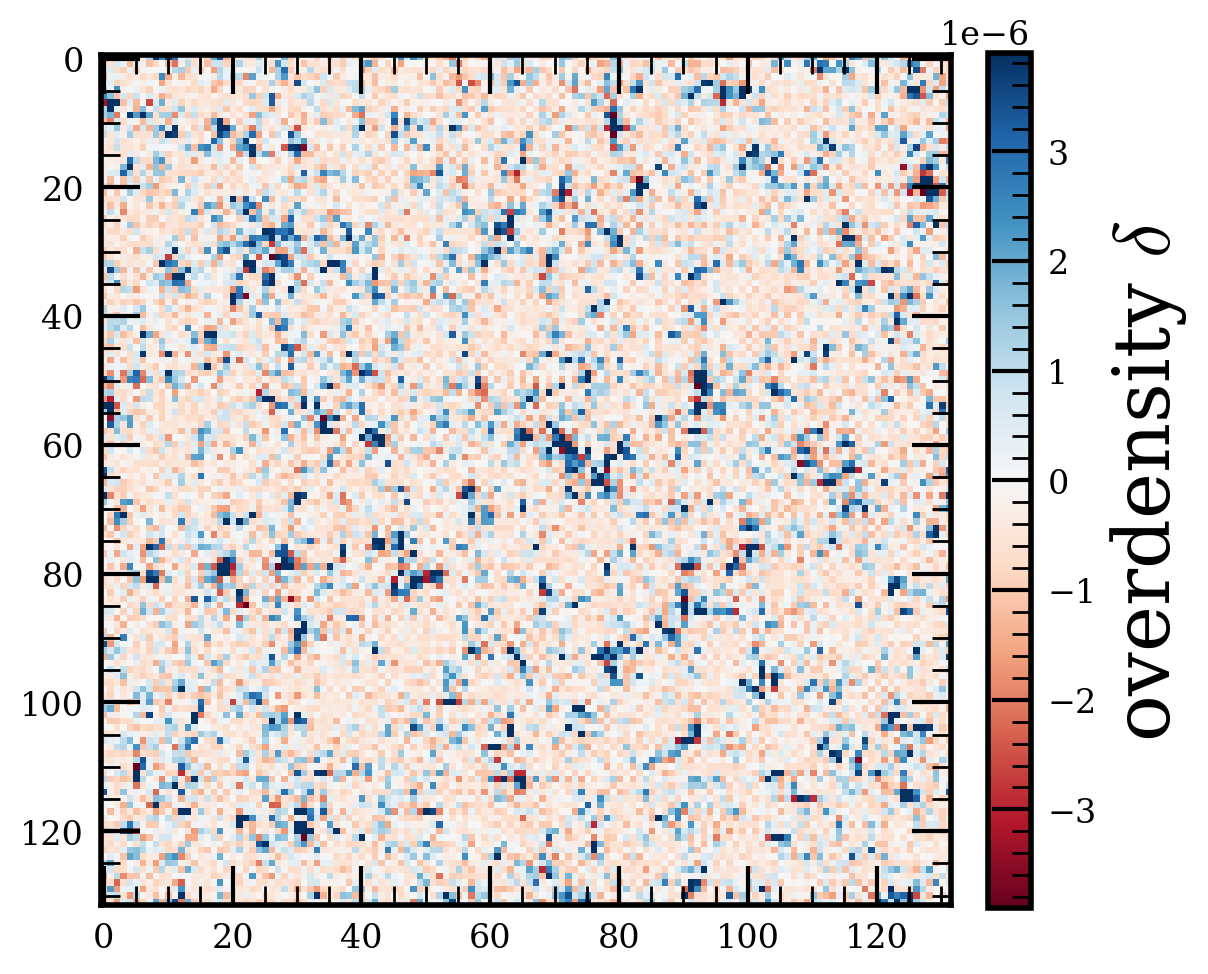

In [19]:
plotter.plot_field(cat_overdensity, overdensity=True)

In [20]:
# close enough to "planck", but should check w raul what exactly was used to create mock
cosmo = utils.get_cosmo(utils.cosmo_dict_quijote)
print(cosmo)


    -----------------------------------------------
            Default cosmology
            LCDM model 
            ------------------------------------
            Ω cold dark matter = 0.2685
            Ω baryon = 0.049
            Ω cold matter = 0.3175
            Ω matter = 0.3175
            Ω dark energy = 0.6825
            Ω neutrino  = 0.0 
            Ω radiation = 0.0
            Ω curvature = 0.0
            Ω total = 1.0
            Σ neutrino mass = 0.0 eV
            Hubble =  67.11 Km/s/Mpc
            ns = 0.9624
            As = 2.133774179915657e-09
            σ8 (cold matter) = 0.834
            σ8 (matter) = 0.8339999914169312
            σ12 (cold matter) = 0.8301801681518555
            σ12 (matter) = 0.8301801681518555
            S8 (matter) = 0.8579802356979493
            w0 = -1.0
            wa = 0.0
            τ = 0.0952
            ------------------------------------
            redshift = 0.0 
            expansion factor = 1
            linear po

In [23]:
pk_obj = cs.compute_pk(cat_overdensity, cosmo, box_size_mock, n_threads=8)

Computing pk, using n_grid =  132


2025-09-07 04:55:55,551 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2025-09-07 04:55:55,636 bacco.statistics :  ...done in 0.0843 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.27422e-07 (grid1) 1.27422e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014441 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.050101 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000224 secs
bacco.power : Deallocating arrays


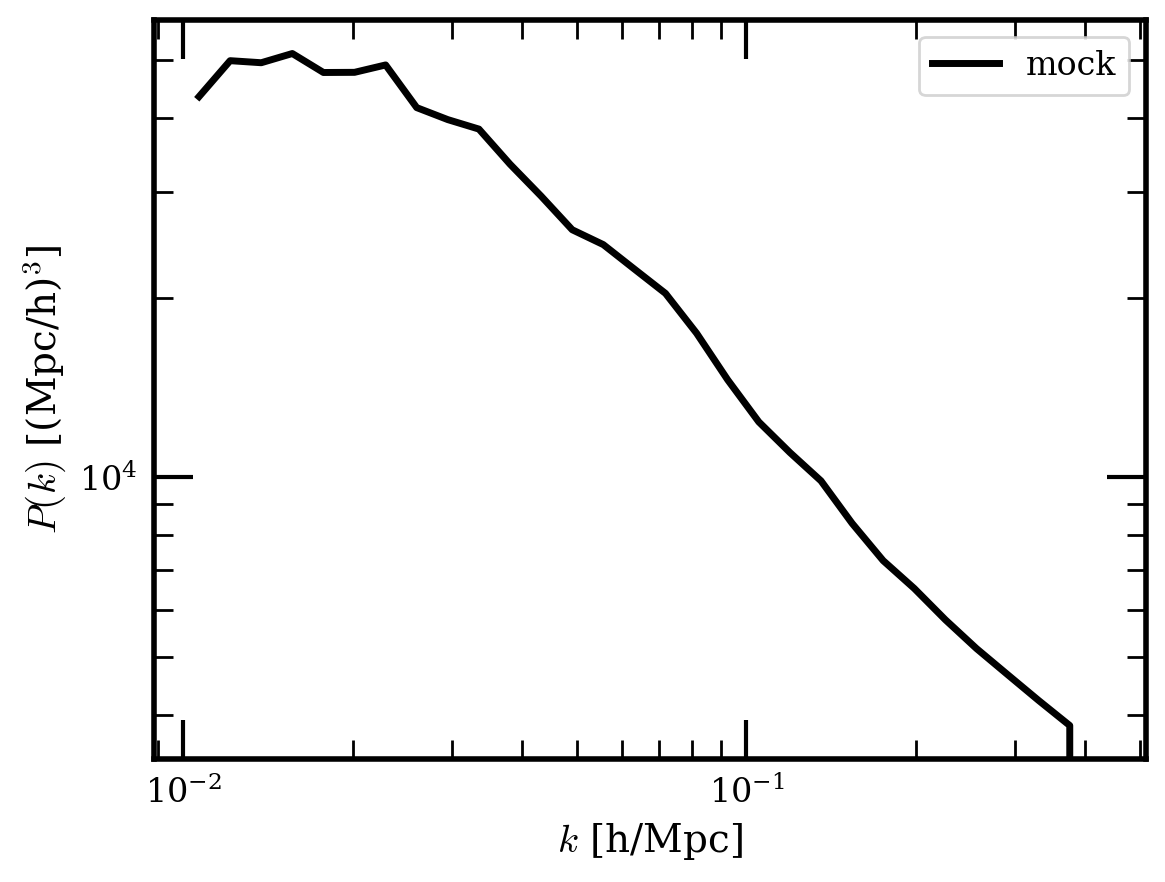

In [24]:
plt.plot(pk_obj['k'], pk_obj['pk'], color='k', label='mock')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

In [25]:
data_mode = 'muchisimocks'
statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
tag_noise = '_noise_test_p5_n1000'
tag_Anoise = '_An_p1_n1000'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
# unpack the power spectrum
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_test_p5_n1000_An_p1_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 30) (1000, 30) (30,)
(1000, 29)
(29,)


In [26]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt (already exists)


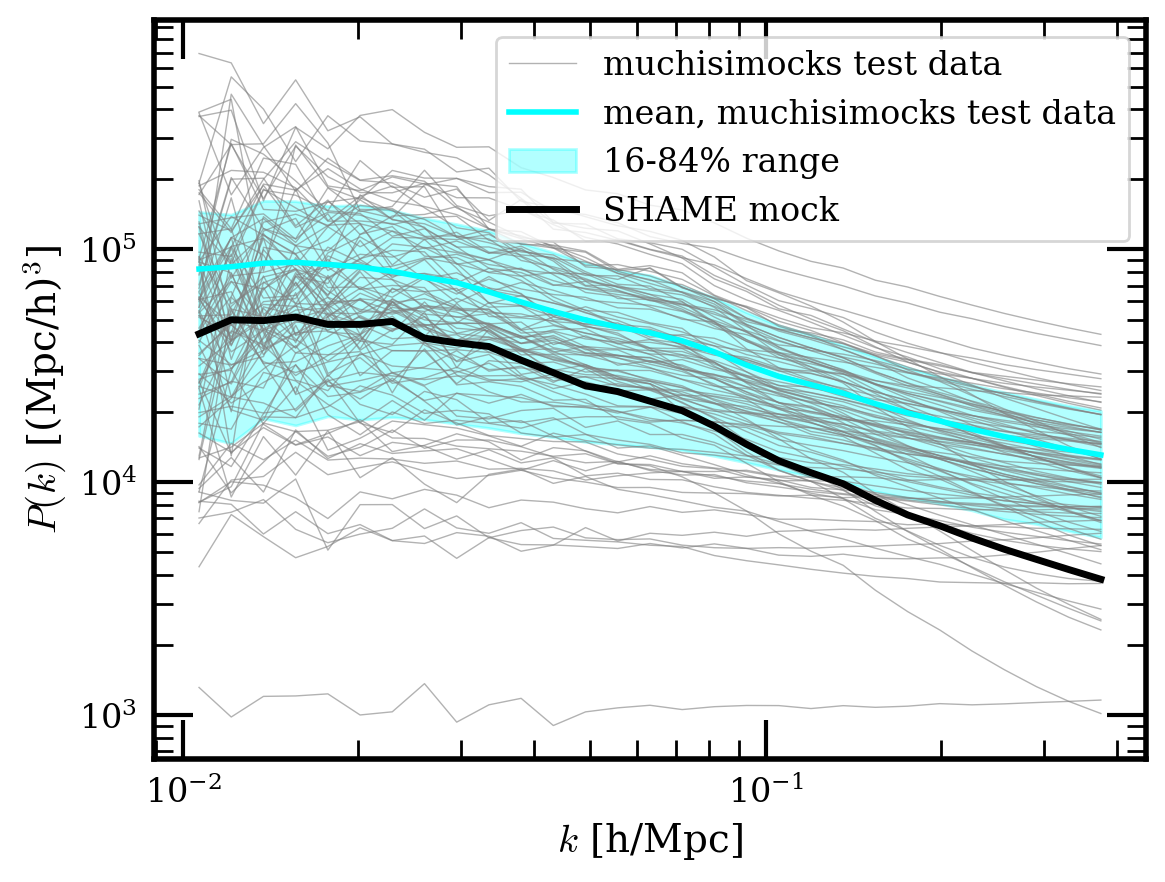

In [27]:
n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k, y[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y, axis=0)
p16 = np.percentile(y, 16, axis=0)
p84 = np.percentile(y, 84, axis=0)
plt.plot(k, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.plot(pk_obj['k'][mask], pk_obj['pk'][mask], color='k', label='SHAME mock')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

## Bispectrum

In [28]:
# TODO issue that when use 1024, nyquist freq is a bit lower and thus lower than default kmax, get error
base = cs.setup_bispsec(box_size_mock, n_grid_mock, n_threads=8)


# Dimensions: [1.02e+03, 1.02e+03, 1.02e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [132, 132, 132]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.405, 0.405, 0.405] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.27 s


In [29]:
bspec, bk_corr = cs.compute_bispectrum(base, cat_overdensity)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [30]:
data_mode = 'muchisimocks'
statistics = ['bispec']


### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
tag_noise = '_noise_test_p5_n1000'
tag_Anoise = '_An_p1_n1000'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
# unpack the power spectrum
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_test_p5_n1000_An_p1_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_test_p5_n1000_An_p1_n1000
Found 1000 diff cosmo bispecs in /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_test_p5_n1000_biaszen_p4_n1000_noise_test_p5_n1000_An_p1_n1000
Loaded bispec data with shape (1000, 50)
No mask for this statistic, using all data
Masked 0 out of 50 bins
(3, 50) (1000, 50) (1000, 50) (50,)
(1000, 50)
(3, 50)


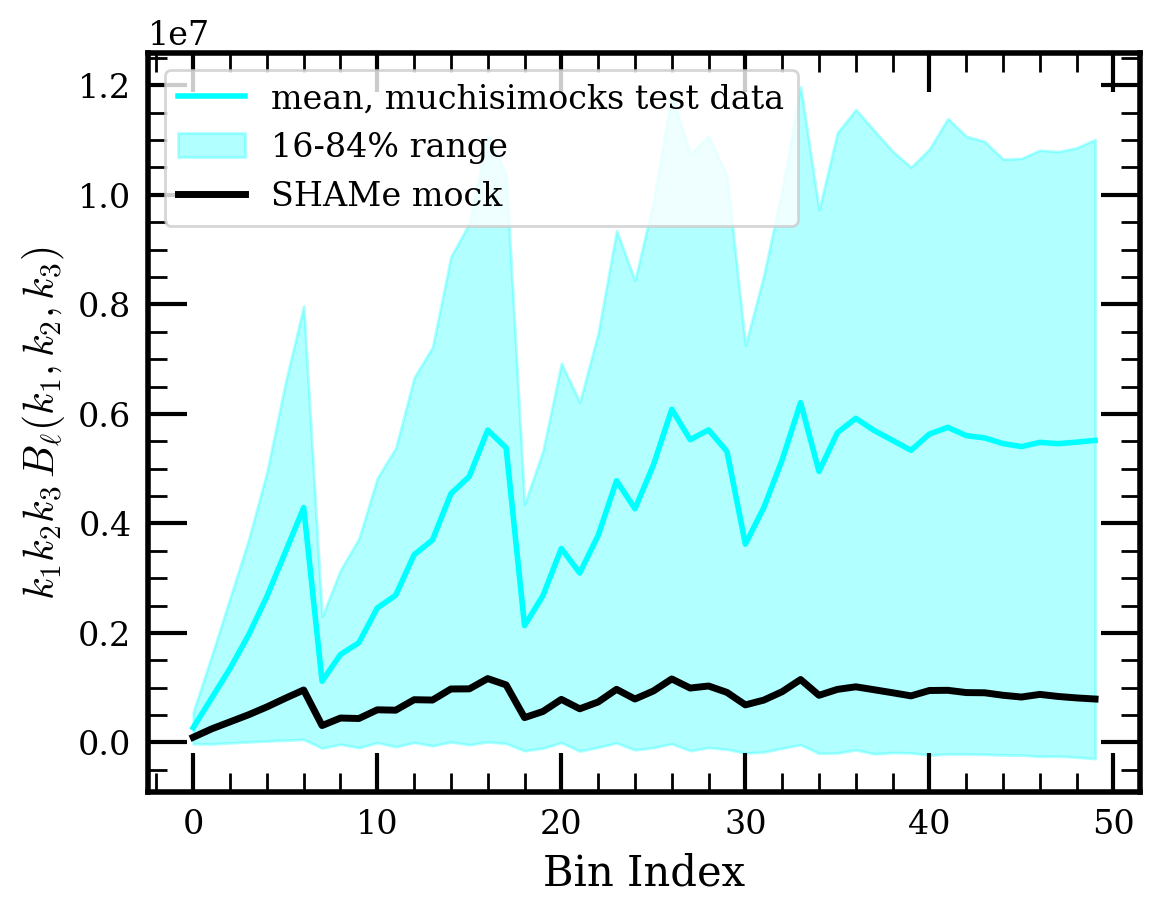

In [31]:


n_plot = 0
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(y[i], color='grey', alpha=0.3, lw=0.5, label=label)
    
mean = np.mean(y, axis=0)
p16 = np.percentile(y, 16, axis=0)
p84 = np.percentile(y, 84, axis=0)
plt.plot(mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(np.arange(len(mean)), p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm_mock = n_grid_mock**3
plt.plot(norm_mock**3 * weight*bk_corr['b0'], color='k', label='SHAMe mock')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        